In [1]:
import nibabel as nib
import os, glob
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.nn import MSELoss
import monai
import torch.nn.functional as F
import monai.networks.nets as nets
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset, PatchDataset
from monai.inferers import SliceInferer
from monai.utils import set_determinism, first
from monai.transforms import(
    Compose,
    Lambdad,
    LoadImaged,
    EnsureChannelFirstd,
    MapTransform,
    SqueezeDimd, 
    RandSpatialCropSamplesd, 
    ScaleIntensityRangePercentilesd, 
    Resized,
    CropForegroundd, 
    CenterSpatialCropd, 
    RandZoomd
)
from monai.losses import DiceCELoss
# print_config()
from datetime import date
today = str(date.today()).replace('-','').replace(' ', '')
gpu_device = torch.device(f'cuda:{0}')

/home/kharroubi/anaconda3/envs/project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Options():
    def __init__(self):
        # I/O
        self.where_is_ProstaTS = '/home/kharroubi/Dataset/Multireader_NIFTI_crop'
        self.Masks_uncertainty = '/home/kharroubi/Dataset/Masks_Agreement_Maps'
        self.RESULTS_DIR = '/home/kharroubi/2Decoders'
        self.EXPERIMENT_PREFIX='SEGTEST'
        self.weights_dir=os.path.join('/home/kharroubi/EXPERIMENTS/SEG', self.EXPERIMENT_PREFIX)
        
        # model parameters
        self.in_channels = 4  # Adjust according to your input image channel dimensions
        self.out_channels = 1  # Adjust according to your output image channel dimensions
        self.num_res_units_G = 9
        self.ROI_SIZE=(128,128,32)
        # training parameters
        self.num_epochs=100
        self.N_train = 60  # number of training samples
        self.learning_rate = 2e-4 #3e-4 #1e-4 #5e-4 #2e-4
        self.lambda_DiceCE=1  
        self.lambda_multi_loss = 1  # Weight for multi-class segmentation loss 
        self.lambda_conf= 1
        self.lambda_CE = 1
        self.val_every=5  #  check val every ? step

opt=Options()

In [3]:
from monai.transforms import MapTransform, Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd, Resized
from monai.data import CacheDataset, DataLoader
import numpy as np
from monai.data.meta_tensor import MetaTensor
import torch
# Custom transform to map specific values
class MapUncMaskValues(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.mapping = {0.0000: 0, 0.49803925: 1, 1.0000: 2}

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                mask = d[key]
                if isinstance(mask, MetaTensor):
                    # Convert MetaTensor to numpy array for processing
                    mask_array = mask.cpu().numpy() if torch.is_tensor(mask) else mask.numpy()
                    conditions = [mask_array == k for k in self.mapping.keys()]
                    choices = list(self.mapping.values())
                    mapped_array = np.select(conditions, choices, default=mask_array)
                    # Convert numpy array back to MetaTensor
                    d[key] = MetaTensor(torch.tensor(mapped_array), meta=mask.meta)
                else:
                    raise TypeError(f"Expected MetaTensor for {key}, but got {type(mask)}")
        return d
        

In [4]:
PIDs_ALL = [i.split('/')[-1] for i in glob.glob(os.path.join(opt.where_is_ProstaTS, 'ANON*'))]
np.random.seed(29100)  # postcode of a beautiful city, will not work if it is not.
np.random.shuffle(PIDs_ALL)

PIDs_train = PIDs_ALL[:opt.N_train]
fnames_train = {seq: [os.path.join(opt.where_is_ProstaTS, PID, PID + f"_{seq}.nii.gz") for PID in PIDs_train] for seq in ['T2', 'B2000', 'Perf', 'ADC']}
fnames_train.update({'MASK_VB': [os.path.join(opt.where_is_ProstaTS, PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs_train],
                     'Unc_MASK': [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs_train]})

train_dic = [{"T2": img1, "B2000": img2, "Perf": img3, "ADC": img4, "MASK_VB": img5, "Unc_MASK": img6 }
             for img1, img2, img3, img4, img5, img6 in zip(*[fnames_train[seq] for seq in ['T2', 'B2000', 'Perf', 'ADC', 'MASK_VB', 'Unc_MASK']])]

PIDs_val = PIDs_ALL[opt.N_train:65]
fnames_val = {seq: [os.path.join(opt.where_is_ProstaTS, PID, PID + f"_{seq}.nii.gz") for PID in PIDs_val] for seq in ['T2', 'B2000', 'Perf', 'ADC']}
fnames_val.update({'MASK_VB': [os.path.join(opt.where_is_ProstaTS, PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs_train],
                     'Unc_MASK': [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs_train]})

val_dic = [{"T2": img1, "B2000": img2, "Perf": img3, "ADC": img4, "MASK_VB": img5, "Unc_MASK": img6 }
           for img1, img2, img3, img4, img5, img6 in zip(*[fnames_val[seq] for seq in ['T2', 'B2000', 'Perf', 'ADC', 'MASK_VB', 'Unc_MASK']])]

train_transforms = Compose(
    [
        LoadImaged(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"], image_only=False),
        EnsureChannelFirstd(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"]),
        ScaleIntensityRangePercentilesd(keys=["T2", "B2000", "Perf", "ADC"], lower=1, upper=99, b_min=-1,b_max=1, clip=True),
        Resized(keys=["T2","B2000","Perf","ADC"], spatial_size=opt.ROI_SIZE, mode="trilinear"),
        Resized(keys=["MASK_VB", "Unc_MASK"], spatial_size=opt.ROI_SIZE, mode="nearest-exact"),
        MapUncMaskValues(keys=["Unc_MASK"])
    ]
)
BATCH_SIZE = 1
NUM_WORKERS = 1
train_ds_fullsize = CacheDataset(train_dic, train_transforms, num_workers=NUM_WORKERS)
train_loader_fullsize = DataLoader(train_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


val_transforms =  Compose(
    [
        LoadImaged(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"], image_only=False),
        EnsureChannelFirstd(keys=["T2","B2000","Perf","ADC", "MASK_VB", "Unc_MASK"]),
        ScaleIntensityRangePercentilesd(keys=["T2", "B2000", "Perf", "ADC"], lower=1, upper=99, b_min=-1,b_max=1, clip=True),
        Resized(keys=["T2","B2000","Perf","ADC"], spatial_size=opt.ROI_SIZE, mode="trilinear"),
        Resized(keys=["MASK_VB", "Unc_MASK"], spatial_size=opt.ROI_SIZE, mode="nearest-exact"),
        MapUncMaskValues(keys=["Unc_MASK"])
    ]
)

val_ds_fullsize = CacheDataset(val_dic, val_transforms, num_workers=NUM_WORKERS)
val_loader_fullsize = DataLoader(val_ds_fullsize, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

Loading dataset:   0%|          | 0/60 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


Unique values in Unc_MASK: metatensor([0., 1., 2.], dtype=torch.float64)


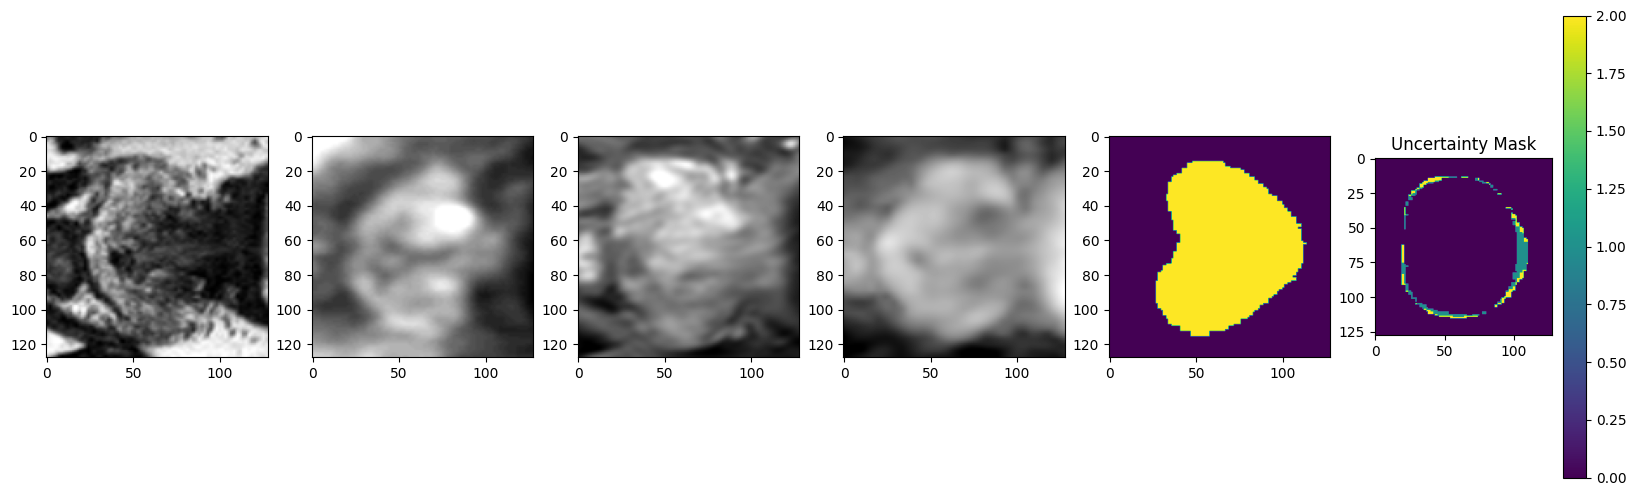

In [5]:
check_data = first(val_loader_fullsize)

# Ensure that all keys are present in check_data
expected_keys = ["T2", "B2000", "Perf", "ADC", "MASK_VB", "Unc_MASK"]
for key in expected_keys:
    if key not in check_data:
        raise ValueError(f"Key {key} not found in check_data.")

plt.figure(figsize=(20,6)) 
plt.subplot(1,6,1)                     
plt.imshow(check_data["T2"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,2)                     
plt.imshow(check_data["B2000"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,3)                     
plt.imshow(check_data["Perf"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,4)                     
plt.imshow(check_data["ADC"][0,0,:,:,16], cmap='gray')
plt.subplot(1,6,5)
plt.imshow(check_data["MASK_VB"][0,0,:,:,16])
plt.subplot(1,6,6)
plt.imshow(check_data["Unc_MASK"][0,0,:,:,16])



# Assuming `train_dataset` is your dataset with `train_transforms` applied
sample = val_ds_fullsize[0]  # Load a sample from the dataset

unc_mask = sample["Unc_MASK"]

# Check unique values to verify categorical labels are preserved
unique_values = torch.unique(unc_mask)
print("Unique values in Unc_MASK:", unique_values)

# Visualize a slice of the Unc_MASK to visually confirm categories
plt.imshow(unc_mask[0, :, :, 16].cpu(), cmap='viridis')  # Adjust slice index as needed
plt.colorbar()
plt.title("Uncertainty Mask")
plt.show()

In [6]:
#2 DEcoder taking the encoder output as input
import torch
import torch.nn as nn
import monai.networks.nets as nets

from monai.networks.blocks.unetr_block import UnetrBasicBlock,UnetrUpBlock
import torch.nn as nn
import torch
from monai.networks.blocks.dynunet_block import UnetOutBlock



class DualUnet_decoder(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
       self,
       spatial_dims,
       in_channels,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride,
       criterion_segmentation,
       criterion_confidence,
       lambda_seg=1.0,
       lambda_conf=1.0,
       out_channels1=1,
       out_channels2=3,
       multipath=1
    ):
    
        super(DualUnet_decoder,self).__init__()

        self.encoder= BasicUnetEnc(spatial_dims,in_channels,features,
                            norm_name,
                            res_block,
                            kernel_sizes,
                            stride
                            ) 
        self.decoder1= CNN_decoder(spatial_dims,
                        multipath,
                        features,
                        norm_name,
                        res_block,
                        kernel_sizes,
                        stride
                        )
        self.decoder2= CNN_decoder(spatial_dims,
                        multipath,
                        features,
                        norm_name,
                        res_block,
                        kernel_sizes,
                        stride
                        )
        self.out1 = UnetOutBlock(spatial_dims=spatial_dims, in_channels=features[0], out_channels=out_channels1)
        self.out2 = UnetOutBlock(spatial_dims=spatial_dims, in_channels=features[0], out_channels=out_channels2)
        
        # Loss functions and lambda parameters
        self.criterion_segmentation = criterion_segmentation
        self.criterion_confidence = criterion_confidence
        self.lambda_seg = lambda_seg
        self.lambda_conf = lambda_conf

    def forward(self, x):
        z=self.encoder(x)
        y1=self.out1(self.decoder1(z)[-1])
        y2=self.out2(self.decoder2(z)[-1])
         # Apply activations
        y1_seg = torch.sigmoid(y1)  # Sigmoid activation for segmentation  
        return y1_seg, y2
        
    
    def compute_losses(self, seg_pred, seg_true, conf_pred, conf_true):
        seg_loss = self.criterion_segmentation(seg_pred, seg_true)
        conf_loss = self.criterion_confidence(conf_pred, conf_true)
        total_loss = self.lambda_seg * seg_loss + self.lambda_conf * conf_loss
        return total_loss, seg_loss, conf_loss   


class BasicUnetEnc(nn.ModuleList):

    def __init__(
       self,
       spatial_dims,
       in_channels,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride
    ):
        super(BasicUnetEnc,self).__init__()
        self.encoderList=nn.ModuleList()
        features=tuple([in_channels])+features

        for i in range(len(features)-1):             
            encoder= UnetrBasicBlock(
                    spatial_dims=spatial_dims,
                    in_channels=features[i],
                    out_channels=features[i+1],
                    kernel_size=tuple(kernel_sizes[i]),
                    stride=tuple(stride[i]),
                    norm_name=norm_name,
                    res_block=res_block
                    )
            self.encoderList.append(encoder)


    def forward(self, x):
        y=[]
        for j in range(len(self.encoderList)):
            x = self.encoderList[j](x)
            y.append(x)
        return y 

"""
DECODER
"""
class CNN_decoder(nn.ModuleList):

    def __init__(
       self,
       spatial_dims,
       multipath,
       features,
       norm_name,
       res_block,
       kernel_sizes,
       stride,
    ):
        super(CNN_decoder,self).__init__()
        self.decoderList=nn.ModuleList()

        for i in range(len(features)-1):
            decoder = UnetrUpBlock(
                    spatial_dims=spatial_dims,
                    in_channels=features[-i-1]* multipath,
                    out_channels=features[-i-2] * multipath,
                    kernel_size=tuple(kernel_sizes[-i-1]),
                    upsample_kernel_size= tuple(stride[-i-1]),
                    norm_name=norm_name,
                    res_block=res_block,
                    )
            self.decoderList.append(decoder)
            
    def forward(self, x):
        y=[]
        x1=x[-1]
        for j in range(len(self.decoderList)):
            x1 = self.decoderList[j](x1,x[-j-2])
            y.append(x1)
        return y   


if __name__ == "__main__":
    criterion_segmentation = DiceCELoss()
    criterion_confidence = DiceCELoss(to_onehot_y=True, softmax=True)
    model= DualUnet_decoder(spatial_dims=3,
                            in_channels=4,
                            features=(32, 64, 128, 256, 320, 512),
                            norm_name='instance',
                            res_block=True,
                            kernel_sizes=[[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]],
                            stride=[[1,1,1],[2, 2, 1], [2, 2, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2]],
                            criterion_segmentation = DiceCELoss(),
                            criterion_confidence = DiceCELoss(to_onehot_y=True, softmax=True),
                            )
    x=torch.rand((1,4,128,128,32))
    y1_seg, y2=model(x)
    print(y1_seg.shape)
    print(y2.shape)
learning_rate = opt.learning_rate  
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=1e-5) #1e-4, weight_decay=1e-5)

torch.Size([1, 1, 128, 128, 32])
torch.Size([1, 3, 128, 128, 32])


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Initialize lists to store losses
train_seg_losses = []
train_conf_losses = []
val_seg_losses = []
val_conf_losses = []

# Best validation loss for early stopping
best_val_loss = float('inf')
current_patience = 0
max_patience = 2

# Move model to GPU
model.to(gpu_device)

# Training loop
for epoch in range(1, opt.num_epochs + 1):
    model.train()
    epoch_train_seg_loss = 0.0
    epoch_train_conf_loss = 0.0
    loop = tqdm(train_loader_fullsize, desc=f"Epoch [{epoch}/{opt.num_epochs}]")

    for batch_idx, real in enumerate(loop):
        real_A = torch.cat([real[key].to(gpu_device) for key in ["T2", "B2000", "Perf", "ADC"]], dim=1)
        real_B_seg = real["MASK_VB"].to(gpu_device)
        real_B_unc = real["Unc_MASK"].to(gpu_device)

        # Forward pass
        y1_seg, y2 = model(real_A)
        
        # Compute losses using model's compute_losses method
        total_loss, seg_loss, conf_loss = model.compute_losses(y1_seg, real_B_seg, y2, real_B_unc)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_train_seg_loss += seg_loss.item()
        epoch_train_conf_loss += conf_loss.item()
        loop.set_postfix(losses=f"[Seg: {seg_loss.item():.4f}, Conf: {conf_loss.item():.4f}] ")

    # Store average training losses for the epoch
    avg_train_seg_loss = epoch_train_seg_loss / len(train_loader_fullsize)
    avg_train_conf_loss = epoch_train_conf_loss / len(train_loader_fullsize)
    train_seg_losses.append(avg_train_seg_loss)
    train_conf_losses.append(avg_train_conf_loss)

    # Validation loop
    if epoch % opt.val_every == 0 or epoch == 1:
        model.eval()
        epoch_val_seg_loss = 0.0
        epoch_val_conf_loss = 0.0
        with torch.no_grad():
            for batch_idx, real_val in enumerate(val_loader_fullsize):
                real_A_val = torch.cat([real_val[key].to(gpu_device) for key in ["T2", "B2000", "Perf", "ADC"]], dim=1)
                real_B_seg_val = real_val["MASK_VB"].to(gpu_device)
                real_B_unc_val = real_val["Unc_MASK"].to(gpu_device)

                # Forward pass
                y1_seg_val, y2_val = model(real_A_val)

                # Compute validation losses using model's compute_losses method
                _, seg_loss_val, conf_loss_val = model.compute_losses(y1_seg_val, real_B_seg_val, y2_val, real_B_unc_val)
                epoch_val_seg_loss += seg_loss_val.item()
                epoch_val_conf_loss += conf_loss_val.item()

            # Calculate average validation losses
            avg_val_seg_loss = epoch_val_seg_loss / len(val_loader_fullsize)
            avg_val_conf_loss = epoch_val_conf_loss / len(val_loader_fullsize)
            val_seg_losses.append(avg_val_seg_loss)
            val_conf_losses.append(avg_val_conf_loss)
            print(f"Epoch {epoch}, Validation Loss: [Seg: {avg_val_seg_loss:.4f}, Conf: {avg_val_conf_loss:.4f}]")

            # Early stopping logic
            avg_val_loss = avg_val_seg_loss + avg_val_conf_loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                current_patience = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                current_patience += 1
                if current_patience >= max_patience:
                    torch.save({'model': model.state_dict()}, os.path.join(opt.weights_dir, opt.EXPERIMENT_PREFIX + '_e%.4d.h38' % epoch))
                    print("Early stopping")
                    break
            # Plot example outputs (you can adjust or add more plots as needed)
            plt.figure(figsize=(20, 10))
            plt.subplot(2, 4, 1)
            plt.imshow(real_A_val[0, 0, :, :, int(opt.ROI_SIZE[2] // 2)].cpu().detach().numpy(), cmap='gray')
            plt.title('Input Image')

            plt.subplot(2, 4, 4)
            plt.imshow(real_B_unc_val[0, 0, :, :, int(opt.ROI_SIZE[2] // 2)].cpu().detach().numpy(), vmin=0, vmax=2, cmap='viridis')
            plt.title('Unc_MASK Ground Truth')

            plt.subplot(2, 4, 5)
            plt.imshow(torch.argmax(y2_val, dim=1)[0, :, :, int(opt.ROI_SIZE[2] // 2)].cpu().detach().numpy(), vmin=0, vmax=2, cmap='viridis')
            plt.title('Confidence Prediction')
            # Plot MASK_VB
            plt.subplot(2, 4, 2)
            plt.imshow(real_B_seg_val[0, 0, :, :, int(opt.ROI_SIZE[2] / 2)].cpu().detach().numpy().squeeze(), vmin=0, vmax=1, cmap='jet')
            plt.title('Mask_VB')

            plt.subplot(2, 4, 3)
            plt.imshow(y1_seg_val[0, 0, :, :, int(opt.ROI_SIZE[2] / 2)].cpu().detach().numpy().squeeze(), vmin=0, vmax=1, cmap='jet')
            plt.title('Segmentation Prediction')

            plt.tight_layout()
            plt.show()
            torch.save({'model': model.state_dict()}, os.path.join(opt.weights_dir, opt.EXPERIMENT_PREFIX + '_e%.4d.h38' % epoch))

Epoch [1/100]:   0%|          | 0/60 [00:00<?, ?it/s]

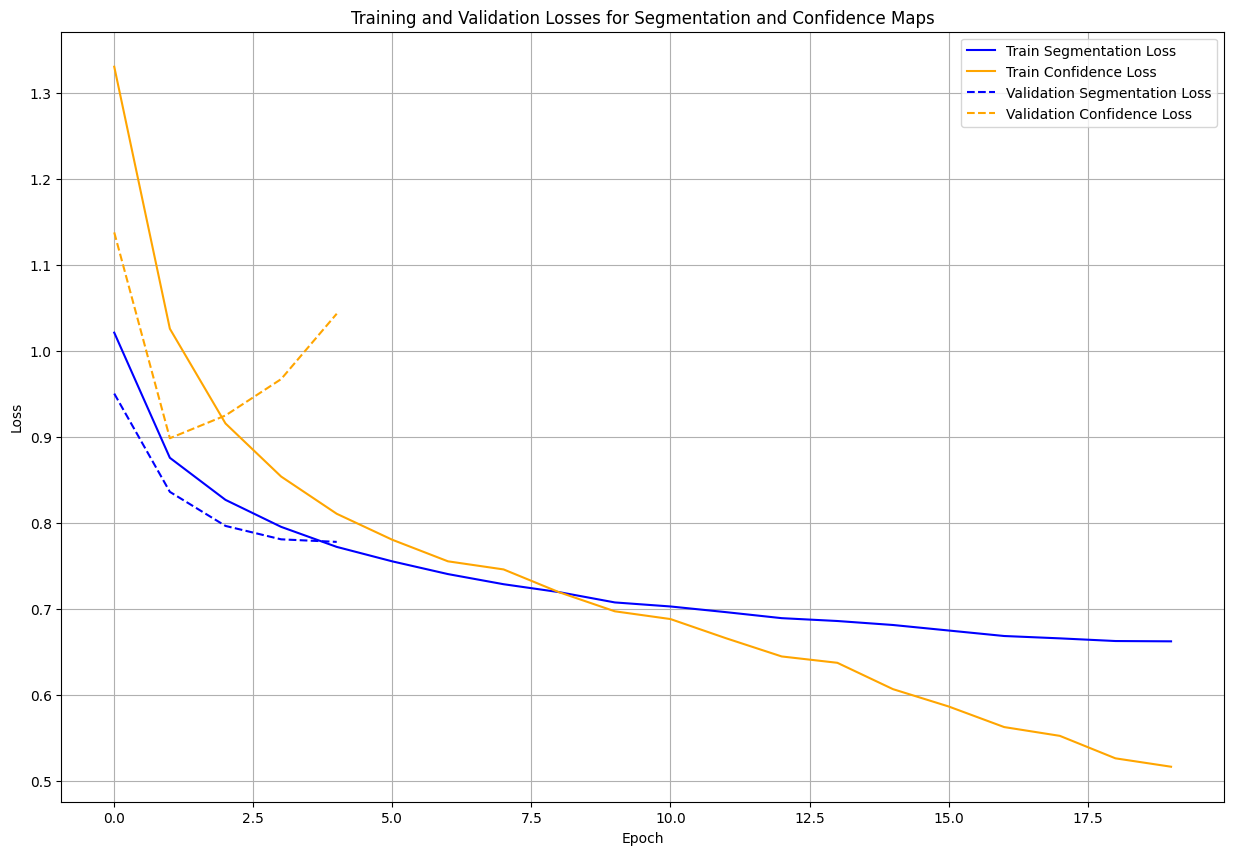

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_seg_losses`, `train_conf_losses`, `val_seg_losses`, `val_conf_losses` are lists containing the respective losses

# Plot losses
plt.figure(figsize=(15, 10))

# Training losses
plt.plot(train_seg_losses, label='Train Segmentation Loss', color='blue')
plt.plot(train_conf_losses, label='Train Confidence Loss', color='orange')

# Validation losses
plt.plot(val_seg_losses, label='Validation Segmentation Loss', linestyle='--', color='blue')
plt.plot(val_conf_losses, label='Validation Confidence Loss', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses for Segmentation and Confidence Maps')
plt.grid(True)
plt.show()

In [ ]:

import os
import nibabel as nib
import torch
import numpy as np
from monai.inferers import SlidingWindowInferer
from monai.transforms import AsDiscrete, Compose

# Define post-processing transforms
post_transforms = Compose([
    AsDiscrete(threshold=0.1, keys=['SEG_PRED', 'CONF_PRED'])
])

# Set ROI size for Sliding Window Inferer
ROI_SIZE = (128, 128, 32)

model.eval()
for i, val_data in enumerate(val_loader_fullsize):
    # Iterate over each modality
    for modality in ["T2", "B2000", "Perf", "ADC"]:
        # Extract the filename for the current modality
        fname = val_data[f"{modality}_meta_dict"]["filename_or_obj"][0]
        print('Processing', fname)
        nii = nib.load(fname)

        val_images = torch.cat([val_data[key] for key in ["T2", "B2000", "Perf", "ADC"]], dim=1).to(gpu_device)

        inferer = SlidingWindowInferer(
            roi_size=ROI_SIZE, 
            overlap=0.75, 
            mode='gaussian',
            sw_batch_size=1
        )

        # Ensure model is on GPU
        model.to(gpu_device)

        # Get segmentation and confidence predictions from the model
        with torch.no_grad():
            y1_seg, y2 = inferer(val_images, model)
        
        # Apply AsDiscrete directly to segmentation and confidence predictions
        y1_seg = AsDiscrete(threshold=0.1)(y1_seg)
        y2 = AsDiscrete(threshold=0.1)(y2)

        # Convert segmentation and confidence predictions to numpy arrays
        y1_seg_np = y1_seg.detach().cpu().numpy()
        y2_np = y2.detach().cpu().numpy()

        # Check shapes for debugging
        print('SEG_PRED shape:', y1_seg_np.shape)
        print('CONF_PRED shape:', y2_np.shape)

        # Save the segmentation output as Nifti image
        nii_out_seg = nib.Nifti1Image(y1_seg_np.squeeze(), None, nii.header)
        fname_out_seg = os.path.join(opt.RESULTS_DIR, os.path.basename(fname).split('.nii.gz')[0] + '_seg_pred.nii.gz')
        nib.save(nii_out_seg, fname_out_seg)

        # Save the confidence output as Nifti image
        nii_out_conf = nib.Nifti1Image(y2_np.squeeze(), None, nii.header)
        fname_out_conf = os.path.join(opt.RESULTS_DIR, os.path.basename(fname).split('.nii.gz')[0] + '_conf_pred.nii.gz')
        nib.save(nii_out_conf, fname_out_conf)

Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON27849/ANON27849_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON27849/ANON27849_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON27849/ANON27849_Perf.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON27849/ANON27849_ADC.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON69112/ANON69112_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON69112/ANON69112_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /h

Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30919/ANON30919_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30919/ANON30919_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30919/ANON30919_Perf.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON30919/ANON30919_ADC.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON70828/ANON70828_T2.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /home/kharroubi/Dataset/Multireader_NIFTI_crop/ANON70828/ANON70828_B2000.nii.gz
SEG_PRED shape: (1, 1, 128, 128, 32)
CONF_PRED shape: (1, 3, 128, 128, 32)
Processing /h

In [ ]:
import os
import glob
import numpy as np
import nibabel as nib
from skimage.transform import resize  # Ensure this import for resizing
from medpy.metric.binary import dc as dice  # Ensure this import for Dice coefficient

# Assuming opt.RESULTS_DIR and opt.Masks_uncertainty are defined elsewhere in your code

# After processing validation data, calculate Dice scores for segmentation and confidence maps
fnames_seg_pred = sorted(glob.glob(os.path.join(opt.RESULTS_DIR, '*_seg_pred.nii.gz')))
fnames_conf_pred = sorted(glob.glob(os.path.join(opt.RESULTS_DIR, '*_conf_pred.nii.gz')))
PIDs = list(set(os.path.basename(fname).split('_')[0] for fname in fnames_seg_pred))  # Unique PIDs
fnames_MASK = [os.path.join('/home/kharroubi/Dataset/Multireader_NIFTI_crop', PID, 'mask_Prostate_VB.nii.gz') for PID in PIDs]
#fnames_MASK = [os.path.join('/home/kharroubi/Dataset/Combined_Masks', f'combined_mask_{PID}.nii.gz') for PID in PIDs]
fnames_unc_MASK = [os.path.join(opt.Masks_uncertainty, PID + '_uncertainty_map.nii.gz') for PID in PIDs]

SCORES_seg = np.zeros(len(PIDs))
SCORES_conf = np.zeros(len(PIDs))

for i, (PID, fname_MASK, fname_seg_pred, fname_conf_pred, fname_unc_MASK) in enumerate(zip(PIDs, fnames_MASK, fnames_seg_pred, fnames_conf_pred, fnames_unc_MASK)):
    try:
        MASK = nib.load(fname_MASK).get_fdata()
        SEG_PRED = nib.load(fname_seg_pred).get_fdata()
        UNC_MASK = nib.load(fname_unc_MASK).get_fdata()
        CONF_PRED = nib.load(fname_conf_pred).get_fdata()

        # Resize the predicted mask to match the shape of the ground truth mask
        SEG_PRED_resized = resize(SEG_PRED, MASK.shape, order=0, preserve_range=True)

        # Resize the predicted confidence map to match the spatial dimensions of the uncertainty mask
        CONF_PRED_resized = CONF_PRED[..., 0]  # Assuming only one channel
        CONF_PRED_resized = resize(CONF_PRED_resized, UNC_MASK.shape, order=0, preserve_range=True)

        # Calculate the Dice score for segmentation and confidence maps
        SCORES_seg[i] = dice(MASK, SEG_PRED_resized)
        SCORES_conf[i] = dice(UNC_MASK, CONF_PRED_resized)

        print(f'{PID}  Seg: {SCORES_seg[i]:.3f}  Conf: {SCORES_conf[i]:.3f}')
    except Exception as e:
        print(f"Error calculating scores for {PID}: {e}")

# Print the average Dice scores
print(f'AVG dice Segmentation: {np.mean(SCORES_seg):.3f} ± {np.std(SCORES_seg):.3f}')
print(f'AVG dice Confidence: {np.mean(SCORES_conf):.3f} ± {np.std(SCORES_conf):.3f}')

ANON30919  Seg: 0.864  Conf: 0.123
ANON69112  Seg: 0.837  Conf: 0.142
ANON70828  Seg: 0.823  Conf: 0.131
ANON78084  Seg: 0.856  Conf: 0.094
ANON79358  Seg: 0.873  Conf: 0.091
ANON24110  Seg: 0.870  Conf: 0.118
ANON27849  Seg: 0.868  Conf: 0.099
ANON13338  Seg: 0.837  Conf: 0.053
ANON19504  Seg: 0.883  Conf: 0.088
ANON30628  Seg: 0.847  Conf: 0.080
AVG dice Segmentation: 0.856 ± 0.018
AVG dice Confidence: 0.102 ± 0.025
